In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import os
import sys

src_dir = './../../src/'
sys.path[0] = src_dir

import matplotlib.pyplot as plt

import glob

import numpy as np
import pandas as pd
import seaborn as sns

from collections import OrderedDict

from access_biology_data import meta, relations, properties
from access_literature_data import medline
from access_science_shared import standardizer 

In [4]:
sys.path.append('./../src/')
from aging_tools import inout, export
from access_aging_data import earlier_studies, chaperome, companions, sequencing

In [5]:
from narrative import nar181026_heat_confidence_genes

from narrative import nar181205_networks

In [6]:
from scipy.stats import spearmanr

In [7]:
from access_aging_data import standardizer as aging_standardizer

In [8]:
outfolder = '200820_vs_non_inflammation'

In [9]:
save_images = True

In [10]:
ref_genes = standardizer.reference_genes(10090, 'orp')

In [11]:
ref_genes_no_trivial = aging_standardizer.filter_reference_genes(
    ref_genes,
    10090,
    'inflammation_et_al'
)

ref_genes_no_trivial = aging_standardizer.filter_reference_genes(
    ref_genes_no_trivial,
    10090,
    'neurons_et_al'
)

In [12]:
pr = properties.genbank_validated_rna(10090)[['gene_ncbi', 'Genbank_validated_RNA: full_SumACGT']].rename(columns={
    'Genbank_validated_RNA: full_SumACGT': 'length'
})

pr.loc[:, 'log_length'] = np.log10(pr['length'])


In [13]:
from natsort import natsorted

In [14]:
all_de, detection, mice_in_comparisons, triplicate_series = nar181026_heat_confidence_genes.load_detection(
    detection_column='padj')

tissues_to_consider = ['BAT', 'Blood', 'GutEP', 'MuscSat', 'Adrenal', 'Kidney',
       'Heart', 'Liver', 'Skin', 'Stomach', 'Brain', 'SI',
       'LI', 'Cerebellum', 'WAT', 'Esophagus', 'Lung'] 


de_set = all_de[
    (all_de['tissue'].isin(tissues_to_consider)) & 
    (all_de['pfu']==0) &
    (all_de['younger']==4) &   
    (all_de['de_unit']=='both') & 
    (all_de['padj'].notnull()) &
    (all_de['gene_ncbi'].isin(ref_genes))

]



In [15]:
renamer = {
        'Adrenal': 'Adrenal Gland', 
        'BAT': 'Brown adipose tissue', 
        'Blood': 'Blood', 
        'Brain': 'Frontal cortex', 
        'Esophagus': 'Esophagus', 
        'GutEP': 'Gut epithelium', 
        'Heart': 'Heart',
        'Kidney': 'Kidney', 
        'LI': 'Large intestine', 
        'Liver': 'Liver', 
        'Lung': 'Lung', 
        'MuscSat': 'Muscle', 
        'SI': 'Small intestine', 
        'Skin': 'Skin',
        'Stomach': 'Stomach', 
        'WAT': 'White adipose tissue', 
        'Cerebellum': 'Cerebellum'}

In [16]:
de_set['tissue'] = de_set['tissue'].replace(renamer)

/Users/tstoeger/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [17]:
from itertools import product

In [18]:
onditions = natsorted(de_set['condition'].unique())
ages = de_set['older'].unique()
out = pd.DataFrame(index=renamer.values(), columns=ages)
out_non_trivial = pd.DataFrame(index=renamer.values(), columns=ages)

for tissue, age in product(renamer.values(), ages):

    d = de_set[
        (de_set['older']==age) &
        (de_set['tissue']==tissue)
    ]

    d = d[['gene_ncbi', 'o_over_y']].dropna()
    d = pd.merge(d, pr)

    r, p = spearmanr(d['log_length'], d['o_over_y'])
    d = d.set_index('gene_ncbi')

    out.loc[tissue, age] = r
    
    
    d = d[d.index.isin(ref_genes_no_trivial)]
    
    r, p = spearmanr(d['log_length'], d['o_over_y'])

    out_non_trivial.loc[tissue, age] = r

In [19]:
a = out.stack().to_frame('value').rename_axis(['tissue', 'age'])
# a.loc[:, 'origin'] = 'orig'
b = out_non_trivial.stack().to_frame('value').rename_axis(['tissue', 'age'])
# b.loc[:, 'origin'] = 'non_trivial'

In [20]:
c = pd.merge(a.reset_index(), b.reset_index(), on=['tissue', 'age'], suffixes=(
'_orig', '_non_trivial'))

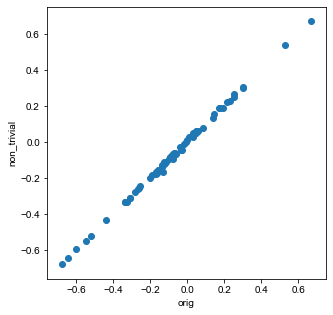

In [21]:
plt.figure(figsize=(5, 5))
plt.scatter(c['value_orig'], c['value_non_trivial'])
plt.xlabel('orig')
plt.ylabel('non_trivial')

if save_images:
    export.export_image(
        '{}/vs_non_inflammation.pdf'.format(
            outfolder))